### Here I will create how to give predictions given some data, this procedure can be wrapped around some rest_api or from some crone job (for scheduled) prediction
**I will give hourly prediction for last 48 hours, from 2010-11-24 21:00:00 to 2010-11-24 20:00:00, we can consider it as suppose we have a schedule at 2010-11-24 21:01:00, it will grab last 48 hours data from somewhere and give the prediction for next 48 hours**
_I already have this data(which is scaled) saved in .npy file, if we don't have that then we need to go through all the pre-processing steps and reshape the data in the format that model can understand_

In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator

In [2]:
# load prediction data
pred_data = np.load("./hourly_models/test_scaled_48_to_48.npy")
# here we have 96 data points, 8 features. But I am interested with only first feature.
# Use first 48 datapoints to predict next 48 (keeping the next 48 data just to compare the results)
pred_data.shape

(96, 8)

In [3]:
# Load the scalar
scalar = joblib.load("./hourly_models/min_max_all_feat_48_to_48.pkl")

In [4]:
# load json and create model
with open("./hourly_models/model_1/model.json", "r") as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
# load weights into the model
model.load_weights("./hourly_models/model_1/model.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# reshape the prediction data
# I am just using the same function for simplicity
# I reality, it will be change and we need to reshape the data as [num_pred_instances, n_input_timestamp=48, n_feature=1]
def get_X_y(data, n_in, n_out=48):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_in
        out_end = in_end + n_out
        # ensuring that we have enough data for this instance
        if out_end <= len(data):
            # need only 1 feature
            x_input = data[in_start:in_end, 0]
            # reshaping [timestemps, features]
            x_input = x_input.reshape((len(x_input), 1))
            # it will give [samples, timestemps, features]
            X.append(x_input)
            # [samples, output]
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [6]:
X_pred, y_pred = get_X_y(pred_data, n_in=48, n_out=48)
print("Pred X shape: ", X_pred.shape)
print("Pred y shape (in reality it won't be there): ", y_pred.shape)

Pred X shape:  (1, 48, 1)
Pred y shape (in reality it won't be there):  (1, 48)


In [7]:
# predict for next 48 hours
predictions = []
# looping so that we can have multiple prediction instances
for arr in X_pred:
    # here array shape is (n_input_timestemps, n_features)
    yhat = model.predict(arr.reshape(1, 48, 1))
    predictions.append(yhat)
predictions = np.array(predictions)

In [8]:
predictions.shape

(1, 1, 48)

In [9]:
# Convert to original scale
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
# just looping so that we can generate multiple prediction instance
original_scale_pred = []
for p in predictions:
    inv_scale_pred = p.flatten() * mult_range + add_min
    original_scale_pred.append(inv_scale_pred)

In [10]:
# Now produce this results for first instance
original_scale_pred[0]

array([139.15167  , 111.19255  ,  75.58911  ,  46.481106 ,  44.343887 ,
        32.518612 ,  20.635359 ,  22.559097 ,  58.40567  ,  88.75606  ,
       110.199104 , 101.646675 ,  93.623604 ,  88.204926 , 102.794395 ,
        97.728096 ,  89.17696  ,  75.361565 ,  50.763973 ,  47.885693 ,
        73.61375  ,  94.38997  , 111.81709  , 117.87449  , 118.3754   ,
       102.76533  ,  89.859634 ,  42.00665  ,  26.067654 ,  18.910297 ,
         3.5335424,  11.897413 ,  53.81986  ,  79.64732  , 106.4982   ,
       111.71307  , 105.67509  , 103.45511  ,  78.44822  ,  60.128876 ,
        46.074547 ,  61.750755 ,  55.019005 ,  45.754536 ,  78.04407  ,
        94.78225  , 111.05079  , 126.83958  ], dtype=float32)

In [11]:
# Create a dataframe to share this (any other way)
df = pd.DataFrame({"local_time": pd.date_range(start="2010-11-24 21:00:00", end="2010-11-26 20:00:00", freq="H"), 
                   "global_active_power": original_scale_pred[0]})
df.set_index("local_time", inplace=True)

In [12]:
df.head()

,global_active_power
local_time,
2010-11-24 21:00:00,139.151672
2010-11-24 22:00:00,111.192551
2010-11-24 23:00:00,75.589111
2010-11-25 00:00:00,46.481106
2010-11-25 01:00:00,44.343887


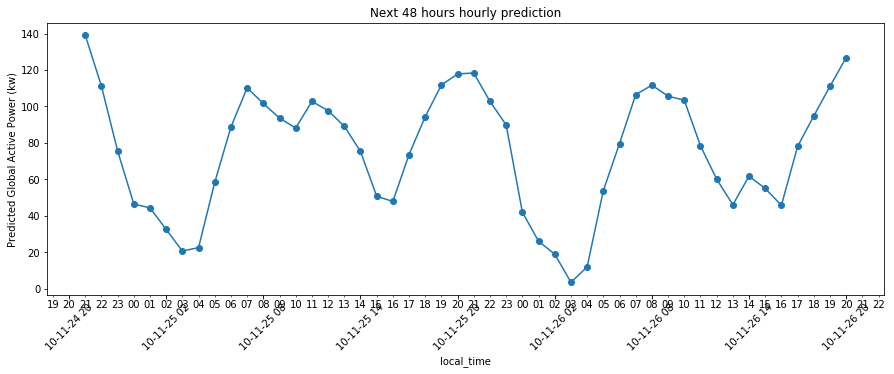

In [13]:
# Can share the visualtization also as a prediction results
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

## Compare actual vs predicted

In [14]:
y_pred.shape

(1, 48)

In [15]:
df["actual_global_active_power"] = y_pred.flatten() * mult_range + add_min

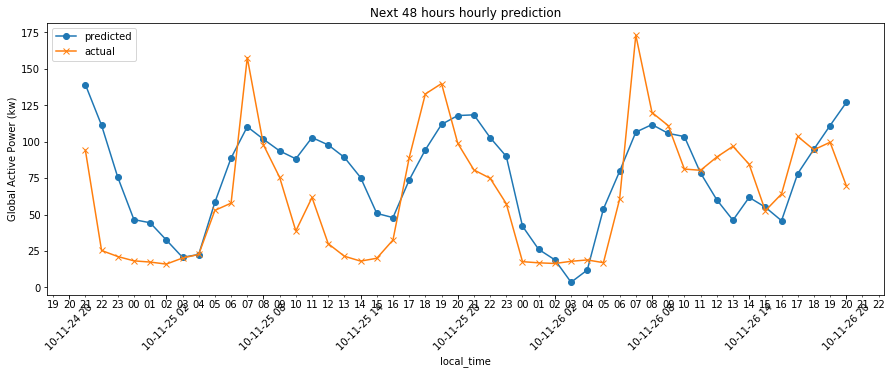

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.plot("actual_global_active_power", data=df, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);